<a href="https://colab.research.google.com/github/harryjkp/Android/blob/master/Risk_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Anonymised Risk Diffusion for the tracking of Asymptomatic Cases of Covid-19 

Isolating suspected cases is a key defense in preventing the spread of infectious diseases. However, if it is the case that asymptomatic cases are still infectious enough to transmit effectively then first-degree contact tracing may not be sufficient to fully dampen the spread. For any disease, one can leverage the relatively safe assumption that it is easier to transmit a bluetooth signal than it is to transmit a disease. In this manner, a connection between two people can anonymously log the predicted infectivity of each person at this connection. This can be done in such a way that risks can be updated retroactively given new information i.e. developing symptoms. The risk score can suggest increased levels of caution and above a certain threshold recommend isolation and a test. Tuning the parameters offers a generalisation between isolating only those with symptoms to a complete lockdown at the most extreme assuming everybody has the app.




# Description of Protocol

Each app tracks two variables over time - the exposure risk and infectivity risk. They are not probabilities but are chosen to equilibriate at the highest risk of two people if they interact long enough rather than continually increasing beyond that. This would assume that a single household effectively has a shared risk of infection. The description as a differential equation would be the following, however discrete updates for each interaction between person i and j are probably more practical.


$$
\frac{dE_i}{dt} = \alpha_I \cdot max(E_j-E_i,0) -\alpha_E\cdot E_i 
 $$

 It could also make sense to include a running averge of E to reflect that while the risk of exposure rises up quickly and decays slowly, the risk of infecting somebody else peaks later. On interaction, both people generate a hash to store a tuple of their encrypted risk scores in a shared database. Storing this hash allows these scores to be read and updated in the future, but does not recognisably connect either person to this datapoint from the perspective of a third party.

 Periodically, the app reads, recalculates and republishes all risk scores. If somebody tests positive, the app writes the maximum possible risk score, decayed appropriately forwards and backwards in time from the date of the test.



# Simulation

As a very simple exploration of this idea I have implemented the following simulation with some idealised assumptions: 

1) Everybody has the app and every interaction is logged.

2) Everybody isolates with 100% adherence.

3) The parameters of the disease are not chosen to accurately reflect Covid-19.

This is supposed to articulate the idea as opposed to suggesting it's effectiveness. It is not implemented efficiently and does not include the private sharing of datapoints. The only thing that it does demonstrate is the possibility of different levels of aggressiveness in approach somewhere between first order contact tracing and a complete lockdown if the paramaters alpha and isolate_at_risk are tweaked.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd,numpy as np

In [0]:
class Person():
  def __init__(self,alpha=0.25,actual_infection_rate=0.2,immunity_rate=0.1,death_from_infection_rate = 0.01,symptom_rate=0.05,isolate_at_risk=0.001):
    self.risk_list = []
    self.risk_list2 = []
    self.interaction_history = []
    self.estimated_infection_date = None
    self.i = 0

    self.risk = 0
    self.immune = False
    self.symptomatic = False
    self.dead = False
    self.actually_infected = False
    self.alpha = alpha
    self.actual_infection_rate = actual_infection_rate
    self.immunity_rate = immunity_rate
    self.death_from_infection_rate = death_from_infection_rate
    self.symptom_rate = symptom_rate
    self.isolate_at_risk = isolate_at_risk
    self.isolate = False
  def test(self):
    # Test assumed to be 100% accurate
    if self.actually_infected:
      self.tested_positive()
    else:
      self.risk = 0 # could be more cautious than this
  def tested_positive(self):
    # Set current risk if infection is confirmed and backdate the risk in
    # compute_risk
    self.risk = 1
    self.immune = True
    self.estimated_infection_date = self.i
  def interacted_with(self,someone_else):
    # Simulate actual transmission of infections as well as the 
    # updates in the app over Bluetooth
    risk_differential = someone_else.risk-self.risk
    if risk_differential>0 and not self.immune:
      self.risk+=self.alpha*(risk_differential)
    if someone_else.actually_infected:
      if np.random.random()<self.actual_infection_rate:
          self.actually_infected = True

  def compute_risk(self):
    # Re-evaluate past and present risk over updated data
    self.risk = 0
    self.risk_list = [0]
    for j in range(self.i):
      # Decay the risk, arbitrarily chosen here to decay by a factor
      # of 10 over a week
      self.risk*=0.72
      interaction = self.interaction_history[j]
      if interaction is not None:
          #Incrementally update the risk from each previous interaction
          risk_differential = interaction.risk_list[j]-self.risk
          if risk_differential>0:
            self.risk+=self.alpha*(risk_differential)
      
      if self.estimated_infection_date != None:
          # If already infected, decay the risk about the infection date.
          self.risk= 1*0.72**abs(j-self.estimated_infection_date)

      self.risk_list.append(self.risk)
            
  def next_day(self):
    
    self.risk_list2.append(self.risk)
    self.risk_list.append(self.risk)
    if self.risk>self.isolate_at_risk and not self.isolate:
      self.isolate = True
      self.risk= 0.1
    if self.risk<0.01:
      self.isolate = False

    self.risk*=0.72 
    if self.immune and self.risk<0.01:
      self.actually_infected = False
      self.symptomatic = False
    if self.actually_infected:
        if np.random.random()<self.immunity_rate:
          self.immune = True
        if np.random.random()<self.death_from_infection_rate:
          self.dead = True
        if np.random.random()<self.symptom_rate:
          self.symptomatic = True



In [0]:
total_tests = 0
test_list=[]

# Initialise 500 people in the population
person_list = [Person() for i in range(500)]

for i in range(10): 
  #Infect 10 people to start with
  person_list[i].actually_infected = True
death_list = []
actually_infected_list = []
isolated_list = []
for i in range(100):
  # Iterate over 100 days. Every day each person interacts with one other at 
  # random unless one of them is dead or isolated.
  dead = 0
  actually_infected = 0
  isolated = 0
  for person in person_list:
    someone_else = np.random.choice(person_list)
    if not (person.isolate or person.dead) and not (someone_else.isolate or someone_else.dead):
      person.interacted_with(someone_else)
      person.interaction_history.append(someone_else)
    else:
      person.interaction_history.append(None)
  for person in person_list:
    #Test people who are predicted to be high risk or have symptoms
    if (person.risk>0.5 or person.symptomatic) and not person.immune and not person.dead:
      person.test()
      total_tests+=1
    
    dead+=person.dead
    if not person.dead:
      # Count total isolated and infected for plotting
      actually_infected+=person.actually_infected
      isolated+=person.isolate
    person.next_day()
  for person in person_list:
    # Recalculate each persons risk history
    person.compute_risk()
    person.i+=1
    
  death_list.append(dead)
  actually_infected_list.append(actually_infected)
  isolated_list.append(isolated)
  test_list.append(total_tests)

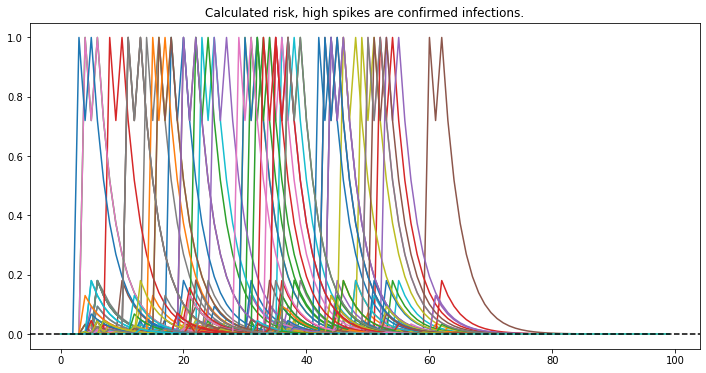

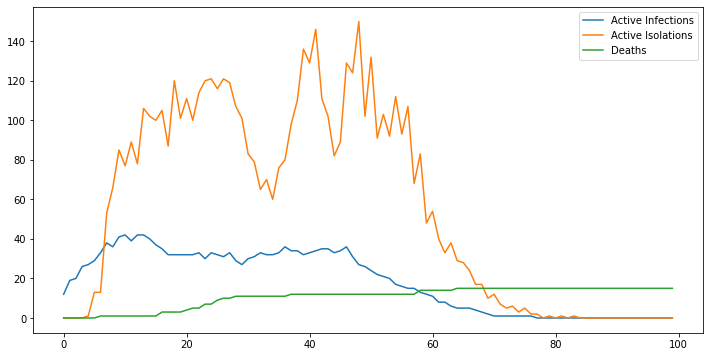

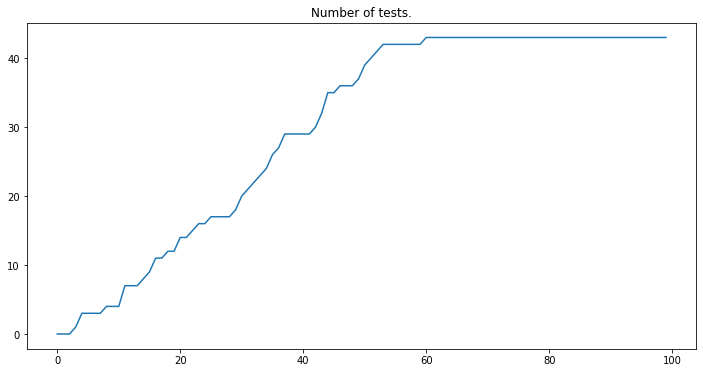

In [0]:
fig = plt.figure(figsize=(12,6))
#plt.yscale('symlog')
plt.title('Calculated risk, high spikes are confirmed infections.')

for person in person_list:
  plt.plot(person.risk_list2)
#plt.axhline(0.1,c='k',ls='--',label='aasd')
plt.axhline(0.0001,c='k',ls='--')
fig = plt.figure(figsize=(12,6))

#fig = plt.figure()
plt.plot(actually_infected_list,label = 'Active Infections')
#fig = plt.figure()
plt.plot(isolated_list,label = 'Active Isolations')
plt.plot(death_list,label='Deaths')
plt.legend()
fig = plt.figure(figsize=(12,6))
plt.title('Number of tests.')
plt.plot(test_list)

# Rough consideration of data sharing

If for each interaction both parties generate a hash or public key for the encryption of their risk score, and the concatenation of these keys is used to store the data of this interaction in a database, then this data should not be meaningful to an outside party. I haven't attempted to encrypt anything in the example below.

In [0]:
class User():
  def __init__(self,app):
    self.app=app
    self.interactions = pd.DataFrame()
    self.interaction_out = pd.DataFrame()
    self.seen_list = []
    self.seen_df = pd.DataFrame()
    self.seen_dict = defaultdict(lambda : defaultdict(lambda:0))
    self.my_risk = 1
  def make_hash(self):
    self.outgoing_hash = str(np.random.random())
    
  def send(self):
    return self.outgoing_hash

  def recieve(self,hash):
    self.seen_list.append((pd.Timestamp.utcnow(),hash))#interactions
    t_dict = self.seen_dict[self.outgoing_hash]
    t_dict['other_hash'] = self.outgoing_hash
    t_dict['shared_key'] = str(np.sort(np.array([hash,self.outgoing_hash])))
    t_dict['time']=pd.Timestamp.utcnow()
    self.seen_dict[self.outgoing_hash] = t_dict
    
  def update_data(self):

    maxval = 0.0
    self.interactions_dict = self.seen_dict.copy()
    for i,v in self.seen_dict.items():
      key = v['shared_key']
      me = i
      other = v['other_hash']
      t = v['time']
      R_other = self.app.shared_dict [key][other]

      self.interactions_dict[i]['risk of interaction']=R_other
      self.interactions_dict[i]['my hash']=i
      elapsed = ((t-pd.Timestamp.utcnow()).total_seconds())/(60*60*24)
      B = elapsed/7.0
      val = 0.9*R_other*np.e**(-B)
      maxval=np.max([val,maxval])


    if maxval==0.0:
      maxval = self.my_risk
    self.app.shared_dict [key][me] = maxval

class App():
  def __init__(self):
    self.shared_dict = defaultdict(lambda : defaultdict(lambda:0))
    self.shared_df = pd.DataFrame()
  def handshake(self,A,B):
    "Exchange hashes"
    A.make_hash()
    B.make_hash()
    A.recieve(B.send())
    B.recieve(A.send())

Covidapp = App()
users = [User(Covidapp) for i in range(20)]


In [0]:
for user in users:
  Covidapp.handshake(np.random.choice(users),user)
for user in users:
  user.update_data()
pd.DataFrame(users[2].interactions_dict).T.set_index('time')

,other_hash,shared_key,risk of interaction,my hash
time,,,,
2020-04-10 19:09:32.617801+00:00,0.18790597363370665,['0.18790597363370665' '0.4302226136279963'],0,0.18790597363370665
2020-04-10 19:09:32.620237+00:00,0.19022879093059164,['0.06777965189891844' '0.19022879093059164'],0,0.19022879093059164
